## Set `UR5` Robot

##### You should run this line ahead.
`roslaunch ur_modern_driver ur5_bringup.launch robot_ip:=192.168.0.100`  in terminal.

#### Define `UR` Class

In [ ]:
import sys 
sys.path.append("..")
import cv2 
import numpy as np 
import time
import rospy
from sensor_msgs.msg import JointState
import matplotlib.pyplot as plt 
print("Done.")


Done.


In [ ]:
class UR_Test():
    def __init__(self):
        self.tick = 0
        self.joint_list = None 
        self.joint_sub = rospy.Subscriber('/joint_states', JointState, self.joint_callback)

        tic_temp=0 

        while self.tick<2: 
            time.sleep(1e-3)
            tic_temp=tic_temp+1

            if tic_temp>5000: 
                print ("[ERROR] GET JOINTS")
                break 
            
    def joint_callback(self, joint_msg):
        """
            Get joint values about each joint.
        """
        self.tick+=1 
        self.joint_list = joint_msg 

#### Get `Initial Pose`

In [ ]:
rospy.init_node('test')
ur_test = UR_Test()

print(ur_test.joint_list.position)
joint_value = ur_test.joint_list.position

(-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105)


### Load Mujoco Engine

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from model.mujoco_parser import MuJoCoParserClass
from model.util import sample_xyzs,rpy2r,r2quat
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.4]


### Parse

In [2]:
xml_path = '../asset/ur5e/scene_ur5e_rg2_obj.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects in a row
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.45,1.65],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0,0,0.8])
print ("Ready.")

dt:[0.0020] HZ:[500]
n_body:[52]
geom_names:['floor', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
n_body:[29]
body_names:['world', 'base', 'shoulder_link', 'upper_arm_link', 'forearm_link', 'wrist_1_link', 'wrist_2_link', 'wrist_3_link', 'tcp_link', 'camera_mount', 'rg2_gripper_base_link', 'camera_center', 'rg2_gripper_finger1_finger_link', 'rg2_gripper_finger1_inner_knuckle_link', 'rg2_gripper_finger1_finger_tip_link', 'rg2_gripper_finger2_finger_link', 'rg2_gripper_finger2_inner_knuckle_link', 'rg2_gripper_finger2_finger_tip_link', 'front_object_table', 'side_object_table', 'base_table', 'obj_cylinder_01', 'obj_cylinder_02', 'obj_cylinder_03', 'obj_cylinder_04', 'obj_cylinder_05', 'obj_cylinder_06', 'obj_cylinder_07', 'obj_cyl

In [3]:
joint_names = env.rev_joint_names[:6]
idxs_forward = [env.model.joint(joint_name).qposadr[0] for joint_name in env.joint_names[:6]]
idxs_jacobian = [env.model.joint(joint_name).dofadr[0] for joint_name in env.joint_names[:6]]
list1, list2 = env.ctrl_joint_idxs, idxs_forward
idxs_step = []
for i in range(len(list2)):
    if list2[i] not in list1:
        idxs_step.append(list1.index(list2[i]))
        

In [4]:
joint_value = [-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105]

### Solve Inverse Kinematics on `Mujoco Engine`

In [ ]:
R_trgt = rpy2r(np.radians([-180,0,90]))

q_ik = env.solve_ik(
    body_name='tcp_link',p_trgt=np.array([0.7, -0.2, 1.20]),R_trgt=R_trgt,
    IK_P=True,IK_R=True, q_init=np.array(joint_value),idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
    RESET=False,DO_RENDER=False,render_every=10,th=1*np.pi/180.0,err_th=1e-3)

print(q_ik)

[-0.72 -1.19  1.9   2.42 -0.85 -3.14]


### Finite State Machine:
#### `1. Grasp Position 2. Lift-up Position 3. Place Postion`

In [27]:
env.init_viewer(viewer_title='UR5e with RG2 gripper and objects',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=124.08,distance=4.00,elevation=-33,lookat=[0.1,0.05,0.86],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.2,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,1.0])
env.reset() # reset
env.forward(q=np.radians([0,-90,0,0,0,0]),joint_idxs=[0,1,2,3,4,5])

# Find the closest object index
obj_idx = np.argmin(xyzs[:,0]) 
obj_name = obj_names[obj_idx]

# Configuration
DO_RENDER = True

# 1. Solve IK for the grasping position
body_name = 'tcp_link'
p_base = env.get_p_body(body_name='base')
p_trgt = env.get_p_body(obj_name); p_trgt[2] = p_base[2] + 0.15
R_trgt = rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_grasp = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=np.radians([0,-90,0,0,0,0]),idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER,th=1*np.pi/180.0,err_th=1e-6)

# 2. Solve IK for the lift-up position
p_trgt = env.get_p_body(obj_name); p_trgt[2] = p_base[2] + 0.15 + 0.5
R_trgt = rpy2r(np.radians([-180,0,90]))
q_liftup = env.solve_ik(body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
                      q_init=np.radians([0,-90,0,0,0,0]),idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
                      RESET=False,DO_RENDER=DO_RENDER,th=1*np.pi/180.0,err_th=1e-6)

# 3. Solve IK for the place position
p_trgt = p_base.copy(); p_trgt[1] = p_base[1] - 0.7; p_trgt[2] = p_base[2] + 0.15 + 0.1
R_trgt = rpy2r(np.radians([-180,0,90]))
q_place = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=np.radians([0,-90,0,0,0,0]),idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
    RESET=False,DO_RENDER=DO_RENDER,th=1*np.pi/180.0,err_th=1e-6)

# Close viewer
env.close_viewer()
print ("IK done.")
print ("q_grasp:%s"%(np.degrees(q_grasp)))
print ("q_liftup:%s"%(np.degrees(q_liftup)))
print ("q_place:%s"%(np.degrees(q_place)))

IK done.
q_grasp:[-64.23 -77.15 133.78 -56.63  25.77  -0.  ]
q_liftup:[-64.23 -96.17  71.37  24.81  25.77  -0.  ]
q_place:[-121.38  -34.57   42.51   -7.94  -31.38    0.  ]


### Get joint position trajectory from `q_grasp` to `q_move`

In [28]:
from model.util import get_interp_const_vel_traj

times,q_traj = get_interp_const_vel_traj(
    np.vstack((q_grasp,q_liftup,q_place)),vel=np.radians(20),HZ=env.HZ)
print ("Joint trajectory ready. duration:[%.2f]sec"%(times[-1]))

Joint trajectory ready. duration:[7.15]sec


In [29]:
def check_pose_done(env, pose):
    return np.linalg.norm((env.get_q(joint_idxs=env.ctrl_joint_idxs[0:6])-pose), ord=np.inf)


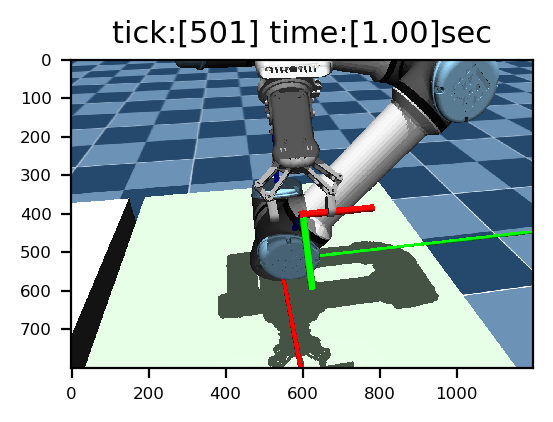

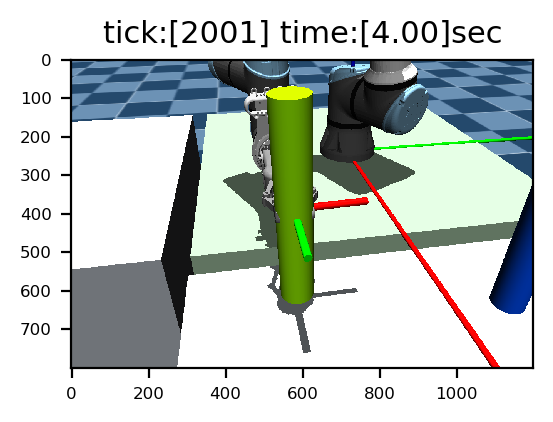

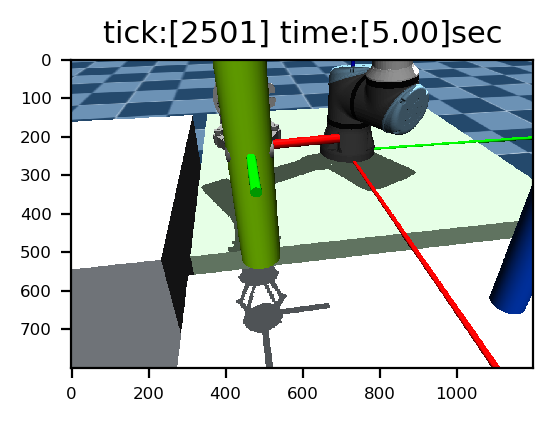

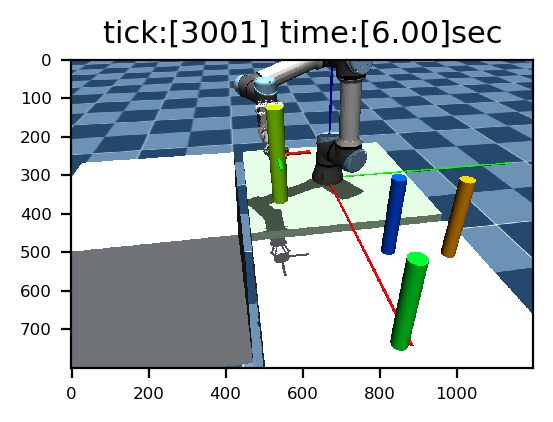

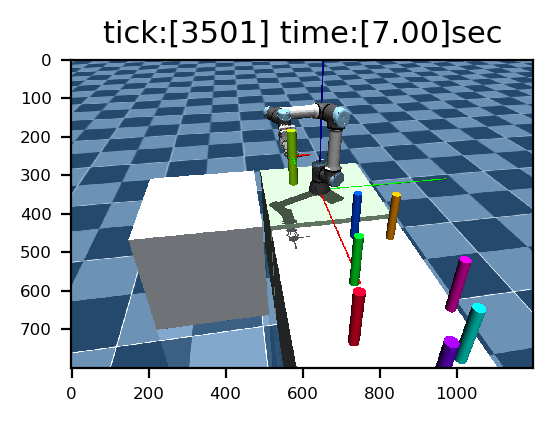

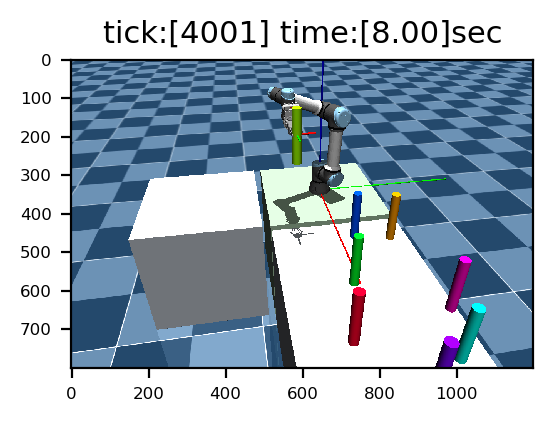

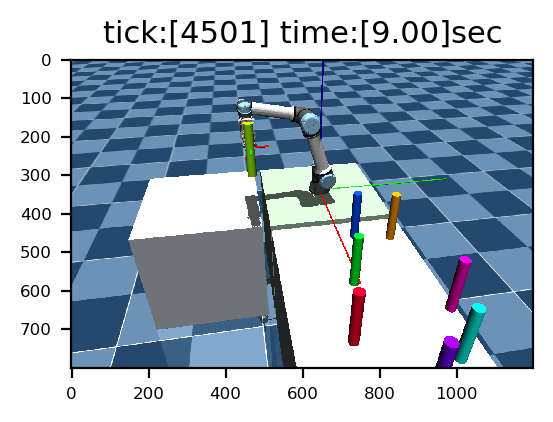

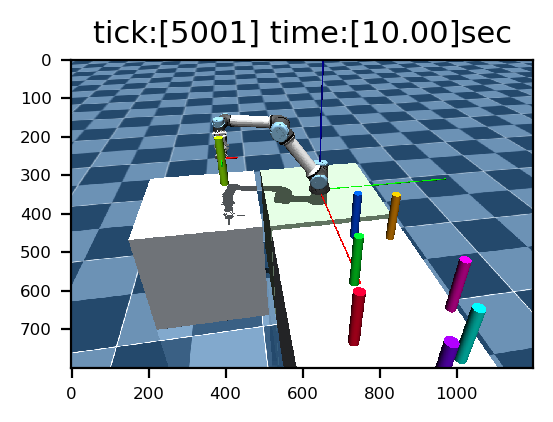

Pressed ESC
Quitting.
Done.


In [31]:
# Gripper openning should be done by calling step()
env.init_viewer(viewer_title='UR5e with RG2 gripper and objects',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=124.08,distance=4.00,elevation=-33,lookat=[0.1,0.05,0.86],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.2,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,1.0])

# Phase
step = 'OPEN_GRIPPER'

# Reset and initialize the joint position
env.reset() # reset
init_configuration = np.array([-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105])
env.forward(q=init_configuration,joint_idxs=[0,1,2,3,4,5])
env.update_viewer(azimuth=170,distance=0.5,lookat=env.get_p_body(body_name='tcp_link'))

# Loop
tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    # Sense
    q_rg2 = env.get_q(joint_idxs=env.ctrl_joint_idxs[6]) # joint position
    f_rg2 = env.data.qfrc_actuator[env.ctrl_joint_idxs[6]] # joint force
        
    # Step
    if step == 'OPEN_GRIPPER':
        env.step(ctrl=init_configuration,ctrl_idxs=[0,1,2,3,4,5])
        env.step(ctrl=1.0,ctrl_idxs=6)
        if q_rg2 > 0.95: step = 'GOTO_GRASP'
    elif step == 'GOTO_GRASP':
        env.forward(q=q_grasp,joint_idxs=[0,1,2,3,4,5])
        env.update_viewer(azimuth=170,distance=0.5,lookat=env.get_p_body(body_name='tcp_link'))
        time_prev = env.get_sim_time()
        step = 'CLOSE_GRIPPER'
    elif step == 'CLOSE_GRIPPER':
        env.step(ctrl=q_grasp,ctrl_idxs=[0,1,2,3,4,5])
        env.step(ctrl=0.0,ctrl_idxs=6)
        time_diff = env.get_sim_time() - time_prev
        if time_diff > 2.0: # after two seconds
            step = 'LIFT_UP_PLACE'
            tick_lift_up = 0
    elif step == 'LIFT_UP_PLACE':
        q = q_traj[tick_lift_up,:]
        tick_lift_up = min(tick_lift_up + 1,q_traj.shape[0]-1)
        env.step(ctrl=q,ctrl_idxs=[0,1,2,3,4,5])
        if tick_lift_up == (q_traj.shape[0]-1):
            step = 'OPEN_GRIPPER2PLACE'
            q_open = env.get_q(joint_idxs=[0,1,2,3,4,5])
    elif step == 'OPEN_GRIPPER2PLACE':
        env.step(ctrl=q_open,ctrl_idxs=[0,1,2,3,4,5])
        env.step(ctrl=1.0,ctrl_idxs=6)
        
    # Render
    #if (step == 'CLOSE_GRIPPER') or (step == 'LIFT_UP_PLACE') or (step == 'OPEN_GRIPPER2PLACE'):
    if (tick-1)%5 == 0:
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_base,R_base = env.get_pR_body(body_name='base')
        env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
        env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.005)
        env.render()
    
    # Plot
    if env.loop_every(HZ=1):
        plt.figure(figsize=(3,2))
        scene_img = env.grab_image()
        plt.imshow(scene_img)
        plt.title('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=11)
        plt.show()
        
print ("Done.")

# Close viewer
env.close_viewer()

### And then, Execute on `Real-Robot`

In [ ]:
import roslib; roslib.load_manifest('ur_driver')
import rospy
import actionlib
from control_msgs.msg import *
from trajectory_msgs.msg import *
from sensor_msgs.msg import JointState
""" FOR ONROBOT RG2 """
from pymodbus.client.sync import ModbusTcpClient
import math

In [ ]:
# TODO: Implement about RealRobot Class.
class RealRobot:
    def __init__(self):
        self.client = None
        self.JOINT_NAMES = ['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint',
                            'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']
        self.arm_pub     = rospy.Publisher('arm_controller/command', JointTrajectory, queue_size = 10)

    def main(self, joint_list=None): 
        try: 
            # rospy.init_node("test_move", anonymous=True, disable_signals=True)
            self.client = actionlib.SimpleActionClient('follow_joint_trajectory', FollowJointTrajectoryAction)
            print("Waiting for server...")
            self.client.wait_for_server()
            print("Connected to server")
            parameters = rospy.get_param(None)
            index = str(parameters).find('prefix')
            if (index > 0):
                prefix = str(parameters)[index+len("prefix': '"):(index+len("prefix': '")+str(parameters)[index+len("prefix': '"):-1].find("'"))]
                for i, name in enumerate(self.JOINT_NAMES):
                    self.JOINT_NAMES[i] = prefix + name
            self.move_trajectory(joint_list=joint_list)

        except KeyboardInterrupt:
            rospy.signal_shutdown("KeyboardInterrupt")
            raise

    def move_trajectory(self, joint_list):
        g = FollowJointTrajectoryGoal()
        g.trajectory = JointTrajectory()
        g.trajectory.joint_names = self.JOINT_NAMES
        for i, q in enumerate(joint_list):
            if i==0:
                joint_states = rospy.wait_for_message("joint_states", JointState)
                joints_pos   = joint_states.position
                g.trajectory.points = [
                    JointTrajectoryPoint(positions=joints_pos, velocities=[0]*6, time_from_start=rospy.Duration(0.0)),
                    JointTrajectoryPoint(positions=q, velocities=[0]*6, time_from_start=rospy.Duration(3))]  
                d=3
            else:
                vel = (q-prev_q) #num_interpol # TODO: CHECK VELOCITY
                g.trajectory.points.append(
                    JointTrajectoryPoint(positions=q, velocities=vel,time_from_start=rospy.Duration(d))) 
            prev_q = q
            d+=0.002
        try:
            print("MOVE")
            self.client.send_goal(g)
            self.client.wait_for_result()
        except:
            raise

    def move_capture_pose(self): 
        try: 
            # rospy.init_node("test_move", anonymous=True, disable_signals=True)
            self.client = actionlib.SimpleActionClient('follow_joint_trajectory', FollowJointTrajectoryAction)
            print("Waiting for server...")
            self.client.wait_for_server()
            print("Connected to server")
            parameters = rospy.get_param(None)
            index = str(parameters).find('prefix')
            if (index > 0):
                prefix = str(parameters)[index+len("prefix': '"):(index+len("prefix': '")+str(parameters)[index+len("prefix': '"):-1].find("'"))]
                for i, name in enumerate(self.JOINT_NAMES):
                    self.JOINT_NAMES[i] = prefix + name
            self.capture_pose()

        except KeyboardInterrupt:
            rospy.signal_shutdown("KeyboardInterrupt")
            raise

    def capture_pose(self):
        try: 
            q = [(-90)/180*math.pi, (-132.46)/180*math.pi, (122.85)/180*math.pi, (99.65)/180*math.pi, (45)/180*math.pi, (-90.02)/180*math.pi]
            g = FollowJointTrajectoryGoal()
            g.trajectory = JointTrajectory()
            g.trajectory.joint_names = self.JOINT_NAMES
            joint_states = rospy.wait_for_message("joint_states", JointState)
            joints_pos   = joint_states.position
            g.trajectory.points = [
                JointTrajectoryPoint(positions=joints_pos, velocities=[0]*6, time_from_start=rospy.Duration(0.0)),
                JointTrajectoryPoint(positions=q, velocities=[0]*6, time_from_start=rospy.Duration(3))]  
            self.client.send_goal(g)
            self.client.wait_for_result()
        except KeyboardInterrupt:
            self.client.cancel_goal()
            raise
        except:
            raise

def euclidean_dist(point1, point2):
    return math.sqrt(sum([math.pow(point1[i] - point2[i], 2) for i in range(len(point1))]))

def get_desired_time(start_pos, target_pos, desired_vel): 
    length = euclidean_dist(start_pos, target_pos)    
    desired_time = length/desired_vel
    return desired_time

In [ ]:
real_robot = RealRobot()


### Set to Initial Pose

In [ ]:
# Set to Initial Pose.
real_robot.move_capture_pose();time.sleep(1)


Waiting for server...
Connected to server


### Set to `Finite-State-Machine` steps

In [ ]:
# TODO: Implement Pick-n-Place pipeline.
# real_robot.main(joint_list=qs_smooth)


Waiting for server...
Connected to server
MOVE
